In [37]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read SkySat data

In [38]:
import glob
import csv
import pymap3d
import dateutil.parser

# read tiff images

input_dir = 'ba_experiments/exp_skysat'

exp = '3s'

myimages = glob.glob(input_dir+'/'+exp+'/*.tiff')
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })
#vistools.display_gallery(mycrops)

# read camera parameters

myfilenames = [os.path.splitext(os.path.basename(image))[0] for image in myimages]

print('myfilenames:', myfilenames)

cam_data = []
file_in = input_dir + '/frame_index.csv'
for i in range(len(mycrops)):
    with open(file_in, 'r', encoding="utf-8") as t_in:
        t_in_reader = csv.DictReader(t_in)
        for row in t_in_reader:
            current_filename = row['name']
            if current_filename == myfilenames[i]:
                q0, q1, q2, q3 = float(row['q0']), float(row['q1']), float(row['q2']), float(row['q3'])
                cam_data.append({'name': current_filename,
                                 'date': dateutil.parser.parse(row['datetime']), 
                                 'x': float(row['x_sat_eci'])*1000.0, 
                                 'y': float(row['y_sat_eci'])*1000.0,
                                 'z': float(row['z_sat_eci'])*1000.0, 
                                 'q0': q0,
                                 'q1': q1,
                                 'q2': q2,
                                 'q3': q3,
                                 'w': 2560.0,
                                 'h': 1080.0,
                                 'f': 692307.69})
                if np.linalg.norm(np.array([q0, q1, q2, q3])) != 1.0:
                    print('Input quaternions are not unit vectors!')
                
#mycrops = mycrops[::-1]
#myfilenames = myfilenames[::-1]
#cam_data = cam_data[::-1]
                
def euler_to_quaternion(roll, pitch, yaw):

        qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
        qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
        qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
        qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)

        return [qx, qy, qz, qw]

def quaternion_to_euler(x, y, z, w):

        import math
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = np.arctan2(t0, t1)

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = np.arcsin(t2)

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = np.arctan2(t3, t4)

        return X, Y, Z

def quaternion_to_R(q0, q1, q2, q3):
    """Convert a quaternion into rotation matrix form.
    https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
    """
    matrix = np.zeros((3,3))
    
    # The diagonal.
    matrix[0, 0] = q0**2 + q1**2 - q2**2 - q3**2
    matrix[1, 1] = q0**2 - q1**2 + q2**2 - q3**2
    matrix[2, 2] = q0**2 - q1**2 - q2**2 + q3**2

    # Off-diagonal.
    matrix[0, 1] = 2.0 * (q1*q2 - q0*q3)
    matrix[0, 2] = 2.0 * (q0*q2 + q1*q3)
    matrix[1, 2] = 2.0 * (q2*q3 - q0*q1)

    matrix[1, 0] = 2.0 * (q1*q2 + q0*q3)
    matrix[2, 0] = 2.0 * (q1*q3 - q0*q2)
    matrix[2, 1] = 2.0 * (q0*q1 + q2*q3)  
    return matrix


# initialize projection matrices

cam_model = 'Perspective'
P_crop = []
for cam in cam_data:
    
    print('\n')
       
    # quaternion_to_R is equivalent to doing the following
    #ax, ay, az = quaternion_to_euler(cam['q1'], cam['q2'], cam['q3'], cam['q0'])
    #R_eci_from_cam = ba_utils.euler_angles_to_R(np.array([ax, ay, az]))
    
    eci_canonical_basis = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    print(cam['date'])
    dates = [cam['date'] for i in range(eci_canonical_basis.shape[0])]
    ecef_basis = pymap3d.eci2ecef(eci_canonical_basis, dates)
    R_ecef_from_eci = ecef_basis.T
    
    R_eci_from_cam = quaternion_to_R(cam['q0'], cam['q1'], cam['q2'], cam['q3'])
    R_cam_from_ecef = np.linalg.inv(R_eci_from_cam) @ np.linalg.inv(R_ecef_from_eci)
    print(np.linalg.det(R_cam_from_ecef),  np.allclose(R_cam_from_ecef.T @ R_cam_from_ecef, np.eye(3)))
    
    C_eci = np.array([cam['x'],cam['y'],cam['z']])
    C_ecef = np.expand_dims(pymap3d.eci2ecef(C_eci, cam['date']), axis=1)
    
    K = np.array([[cam['f'], 0.0, float(cam['w'])/2], [0.0, cam['f'], float(cam['h'])/2], [0.0, 0.0, 1.0]])
    
    
    #current_P = K @ np.hstack(( R_cam_from_ecef, C_ecef))
    #current_P = K @ R_cam_from_ecef @ np.hstack((np.eye(3), -C_ecef))
    current_P = K @ R_cam_from_ecef @ np.hstack((np.eye(3), -C_ecef))
    
    current_P = current_P/current_P[2,3]
    
    #tmp =  current_P[0,:]
    #current_P[0,:] = current_P[1,:]
    #current_P[1,:] = tmp    

    
    #P_crop.append(current_P/current_P[2,3])
    
    P_crop.append(current_P)
    
print('\nRPCs successfully approximated as projection matrices')

Found 3 images
Number of images to be used: 3
myfilenames: ['1223201791.24831295_sc00003_c1_PAN', '1223201794.24880314_sc00003_c1_PAN', '1223201788.24781990_sc00003_c1_PAN']
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!


2018-10-10 10:16:13+00:00
1.000000079113574 True


2018-10-10 10:16:16+00:00
0.999999522211632 True


2018-10-10 10:16:10+00:00
1.0000032547741422 True

RPCs successfully approximated as projection matrices


### Import feature tracks

In [39]:
import pickle

pickle_in = open("features_3s.pickle","rb")
feature_tracks, r = pickle.load(pickle_in)

C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)

# remove uncomplete tracks
C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

print('Found {} complete tracks'.format(C.shape[1]))

# invert the coordinates of the feature tracks
C2 = np.zeros(C.shape)
C2[::2,:] = C[1::2,:]
C2[1::2,:] = C[::2, :]
C = C2.copy()

Found 9920 complete tracks


In [40]:
# Select a random subset of 1000 obs

#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (4000,), replace=False)
#C = C[:,idx_to_preserve]

#C.shape[1]

### Initialize 3D points

In [41]:
pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('Initial 3D points:\n', pts_3d)

Initial 3D points:
 [[3734176.22048467  637818.55481453 5114828.78435362]
 [3735203.67446232  637714.63413883 5114050.54419505]
 [3735053.92922017  637722.06995182 5114155.17658394]
 ...
 [3734655.0301866   637461.91487591 5119163.34912648]
 [3735294.9354706   637449.54496004 5118744.14679374]
 [3734765.25010541  637477.38892943 5119113.9093814 ]]


### Define BA input parameters

In [42]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=True, opt_K=True)

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{} cam_params_opt.shape:{}\n'.format(pts_3d.shape, cam_params.shape, cam_params_opt.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

pts_2d.shape:(29760, 2)  pts_ind.shape:(29760,)  cam_ind.shape:(29760,)
pts_3d.shape:(9920, 3)  cam_params.shape:(3, 11) cam_params_opt.shape:(3, 11)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run BA

(29783,)
Shape of matrix A: 59520x29783
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5162e+05                                    1.87e+10    
       1              9         5.6826e+04      9.48e+04       1.41e+02       1.84e+10    
       2             10         2.4798e+04      3.20e+04       3.02e+02       2.51e+10    
       3             11         1.3377e+04      1.14e+04       6.42e+02       1.27e+10    
       4             12         7.1370e+03      6.24e+03       1.57e+02       4.40e+09    
       5             13         3.8042e+03      3.33e+03       8.73e+02       3.54e+09    
       6             14         2.5647e+03      1.24e+03       7.14e+02       1.36e+09    
       7             15         1.9837e+03      5.81e+02       6.25e+02       7.36e+08    
       8             16         1.1089e+03      8.75e+02       1.22e+03       5.68e+08    
       9             17         5.5663e+02      5.

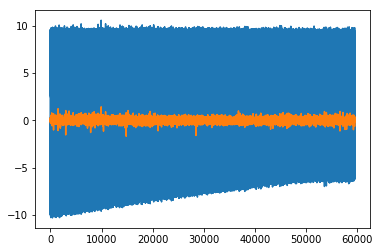

In [43]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
    print(x0.shape)
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [44]:
print(P_crop[0]/P_crop[0][-1,-1])
print(P_crop_ba[0])

[[ 1.41232242e-01  7.07196256e-02 -2.35965669e-03 -5.60395126e+05]
 [ 5.86549080e-02 -1.14060838e-01  9.22119116e-02 -6.17919199e+05]
 [ 5.76118413e-08 -1.20289937e-07 -1.85133070e-07  1.00000000e+00]]
[[ 1.40750687e-01  7.04763461e-02 -2.36348102e-03 -5.58421914e+05]
 [ 5.86303680e-02 -1.14001035e-01  9.21743011e-02 -6.17673849e+05]
 [ 5.75757724e-08 -1.20247289e-07 -1.85039824e-07  1.00000000e+00]]


In [47]:
cam_params_ba

array([[-2.56532608e+00, -2.55213708e-01,  3.93647213e-01, -3.55531714e+06, -3.91542547e+06,  4.38469498e+06,  6.90268146e+05,  6.92307690e+05,
        -6.08212656e-11,  1.28000000e+03,  5.40000000e+02],
       [-2.55817235e+00, -2.35246726e-01,  3.90980156e-01, -3.48334261e+06, -3.90773461e+06,  4.44706408e+06,  6.90268146e+05,  6.92307690e+05,
        -6.08212656e-11,  1.28000000e+03,  5.40000000e+02],
       [-2.57244720e+00, -2.74681915e-01,  3.96436149e-01, -3.62391894e+06, -3.92280317e+06,  4.32322266e+06,  6.90268146e+05,  6.92307690e+05,
        -6.08212656e-11,  1.28000000e+03,  5.40000000e+02]])

In [13]:
#K, R, vecT, C = ba_utils.decompose_projection_matrix(P_crop_ba[0])

#print(R)

[[ 0.89364184  0.44857968 -0.01343601]
 [ 0.37100462 -0.72159237  0.58451691]
 [ 0.25250709 -0.52733359 -0.81127027]]


### Check BA error

Error before BA (mean / median): 11.11 / 11.91
Error after  BA (mean / median): 0.18 / 0.14


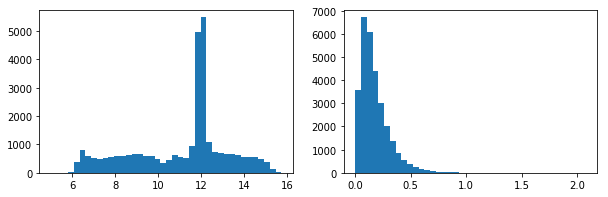

In [48]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [677]:
max(C[1,:])

2481.589111

 ----> Real 2D loc in im 0  (sol) =  [ 539.455017 1371.695557]
 ----> Proj 2D loc in im 0  b. BA =  [ 539.19374027 1377.30969738]
 -----------> Reprojection error: 5.875417109035652
 ----> Real 2D loc in im 1  (sol) =  [ 498.424622 1422.455811]
 ----> Proj 2D loc in im 1  b. BA =  [ 498.69269617 1416.57228063]
 -----------> Reprojection error: 6.151604541388792

3D coordinates: [3734982.53414339  637326.22174874 5116492.5817312 ]
lat, lon: 53.662, 9.684, alt: 2391.112


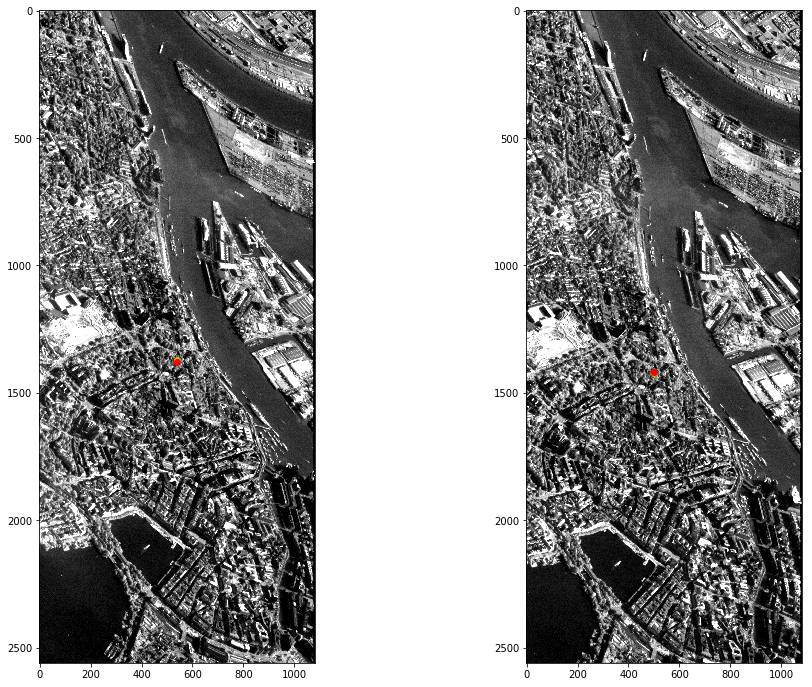

In [78]:
n_pts = C.shape[1]
#p_ind = pts_ind[np.argmax(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])][:2]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))

i1, i2 = im_ind[0], im_ind[1]
pt1 = C[(i1*2):(i1*2+2),p_ind]
pt2 = C[(i2*2):(i2*2+2),p_ind]
le_pt_3d = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop[i1], P_crop[i2])
#le_pt_3d[:2] = le_pt_3d[:2][::-1]
                                            
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    
    #proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    #p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((le_pt_3d, np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    #reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    #if cont == 0:
        #print('3D location a. triangulation:', pts_3d[p_ind,:].ravel())
        #print('3D location a. bundle adjust:', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' b. BA = ', p_2d_proj.ravel())
    print(' -----------> Reprojection error:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    #print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel(), '\n')
    
    im = 255.*np.ones((1000,1000))
    #f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].imshow((mycrops[i]['crop'].T), cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    #f[cont].plot(*p_2d_proj_ba, "ro")
    
#print('Reprojection error a. BA: ', reprojection_error_ba)

print('\n3D coordinates:', le_pt_3d)

x , y, z = le_pt_3d[0], le_pt_3d[1], le_pt_3d[2]
lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
print('lat, lon: {:.3f}, {:.3f}, alt: {:.3f}'.format(lat, lon, h))

In [18]:
os.chdir('../IS18/')

In [701]:
# check the distance between the two projection rays for the 3d point p_ind

K, R, vecT, C1 = ba_utils.decompose_projection_matrix(P_crop_ba[i1])

dir_vec_ray1 = np.linalg.inv(K @ R) @ np.expand_dims(np.hstack((pt1, np.ones(1))), axis=1)

print(dir_vec_ray1)

K, R, vecT, C2 = ba_utils.decompose_projection_matrix(P_crop_ba[i2])

dir_vec_ray2 = np.linalg.inv(K @ R) @ np.expand_dims(np.hstack((pt2, np.ones(1))), axis=1)

print(dir_vec_ray2.shape)

# eq of ray 1 --> ray1 = C1 + t * dir_vec_ray1, where t is an scalar 
# eq of ray 2 --> ray2 = C2 + t * dir_vec_ray2, where t is an scalar

n = np.cross(dir_vec_ray1, dir_vec_ray2, axis=0)
d = np.dot((C2 - C1), n) / np.linalg.norm(n)

print('distance is {} m'.format(np.linalg.norm(d)))

[[ 1104486.777576  ]
 [-2318789.28096725]
 [-3551183.30286891]]
(3, 1)
distance is 0.526886687396455 m


In [50]:
from PIL import Image

#project the dsm of sift points and the triangulation error BEFORE BA


col = np.array([[255,   0, 0], [0,   255,   0], [0,   0,   255], [255, 255, 0], [255, 0, 255], [0, 255, 255], 
                [255, 155, 0], [155, 255,   0], [155, 0,   255], [255, 0, 155], [0, 255, 155], [0, 155, 255],
                [0,     0, 0], [255, 255, 255], [155, 155, 155]])

#_,f = plt.subplots(1, 2, figsize=(10,3))

folder = 'ba_experiments/exp_skysat/3s/l1_fx'


n_pts = C.shape[1]
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1

        pts_3d_tmp = np.zeros((n_pts,3))
        tr_err_tmp = np.zeros((n_pts,1))
        
        #current_pair = [0,5]
        #q,p = current_pair[0], current_pair[1]
        
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop[q], P_crop[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)
            tr_err_tmp[i,0] = ba_utils.dist_between_proj_rays(pt1,pt2,P1,P2)

        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T

        ba_utils.write_point_cloud_ply(folder+'/3s_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])

        emin, emax, nmin, nmax = min(east), max(east), min(north), max(north)
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_dsm_{}_{}.tif'.format(q,p))
        xyz = np.vstack((east, north, tr_err_tmp.ravel())).T
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_tr_err_{}_{}.tif'.format(q,p))

        #f[0].hist(tr_err_tmp.ravel(), bins=40); 

        #project the dsm of sift points and the triangulation error AFTER BA

        pts_3d_tmp = np.zeros((n_pts,3))
        tr_err_tmp = np.zeros((n_pts,1))

        for i in range(C.shape[1]):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba[q], P_crop_ba[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)
            tr_err_tmp[i,0] = ba_utils.dist_between_proj_rays(pt1,pt2,P1,P2)

        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T

        ba_utils.write_point_cloud_ply(folder+'/3s_{:02}_{:02}_ba.ply'.format(q,p), xyz, color=col[cont,:])

        emin, emax, nmin, nmax = min(east), max(east), min(north), max(north)
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_dsm_{}_{}_ba.tif'.format(q,p))
        xyz = np.vstack((east, north, tr_err_tmp.ravel())).T
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_tr_err_{}_{}_ba.tif'.format(q,p))

        #f[1].hist(tr_err_tmp.ravel(), bins=40); 
        print('done!')

done!
done!
done!


In [617]:
dir_vec_ray1 = np.array([1,1,2])
dir_vec_ray2 = np.array([1,1,3])

C1 = np.array([0,2,-1])
C2 = np.array([1,0,-1])

n = np.cross(dir_vec_ray1, dir_vec_ray2)

d = np.dot((C2 - C1), n) / np.linalg.norm(n)

print('distance is {} m'.format(d))

[ 0  2 -1]
[ 1 -2  0]
distance is 2.1213203435596424 m


In [599]:
(float(3)/2) *np.sqrt(2)

2.121320343559643

In [614]:
3* np.sqrt(133)

34.59768778401239

In [ ]:
### visualize initial reprojection errors

mode = 'output'

if mode == 'input':
    err = np.add.reduceat(abs(f0), np.arange(0, len(f0), 2))
else:
    err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))

thr = np.quantile(err, 0.5)
print(thr)

#thr = np.inf

in_e, ba_e = [], []


i = 0
pts_gt, pts_reproj = [], []
for j in range(C.shape[1]):
    if not np.isnan(C[i*2,j]):
        p_2d_proj = np.reshape(C[(i*2):(i*2+2),j], (2,1))
        proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[j,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1] 
        proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
        reproj_ba = proj[0:2,:] / proj[-1,-1]  
        abs_reproj_e = np.sum(abs(p_2d_proj - reproj))
        abs_reproj_e_ba = np.sum(abs(p_2d_proj - reproj_ba))
        
        in_e.append(abs_reproj_e)
        ba_e.append(abs_reproj_e_ba)
        
        if mode == 'input':
            tmp = abs_reproj_e
        else:
            tmp = abs_reproj_e_ba
        
        #print(abs_reproj_e)
        
        if tmp < thr:
            pts_gt.append(p_2d_proj)
            
            if mode == 'input':
                pts_reproj.append(reproj)
            else:
                pts_reproj.append(reproj_ba)
                
pts_gt, pts_reproj = np.array(pts_gt)[:,:,0], np.array(pts_reproj)[:,:,0]

print(pts_gt.shape[0])

print('mean abs reproj error in image {} is {}'.format(i, np.mean(ba_e))) 

# image 0
_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(in_e, bins=40); 
f[1].hist(ba_e, bins=40);

In [ ]:
f = plt.figure(figsize=(9,9))
plt.imshow((mycrops[i]['crop']), cmap="gray")
for i in range(pts_gt.shape[0]):
    plt.plot([pts_gt[i,1], pts_reproj[i,1] ], [pts_gt[i,0], pts_reproj[i,0]], 'r-')
    plt.plot(*pts_gt[i,::-1], 'yx')
    
plt.show()

In [650]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)


col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba[q], P_crop_ba[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        print(q,p)
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_new_l2_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])

Initial 3D points:
 [[3735026.44874137  636883.18933002 5117671.29618044]
 [3735586.22708225  636926.6585521  5116130.10999212]
 [3735117.66111745  636919.3776392  5117173.7222206 ]
 ...
 [3735065.51977522  636966.72305348 5116587.77189599]
 [3735614.20527323  636911.08428828 5116315.99619817]
 [3734885.707383    637028.73342694 5115722.72285194]]
Before BA:
x: 3734320.094, 3735890.163,    y: 636810.914, 637225.989,     z: 5113015.638, 5118181.826
lat: 53.639, 53.672,    lon: 9.674, 9.684,     alt: -58.348, 3755.261
0 1
Initial 3D points:
 [[3735034.18124763  636866.90491112 5117645.29612796]
 [3735581.58075793  636936.30127826 5116143.00924482]
 [3735116.50033403  636921.77545746 5117176.5652308 ]
 ...
 [3735065.5727579   636966.57044719 5116586.63921291]
 [3735609.69867892  636920.40738914 5116327.8129265 ]
 [3734883.49097981  637033.43757839 5115731.00646481]]
Before BA:
x: 3734326.185, 3735886.185,    y: 636798.012, 637211.601,     z: 5113013.032, 5118191.746
lat: 53.639, 53.672,  

In [ ]:
C.shape

In [ ]:
# Project X_ba with P_ba -> tracks_ba
# Run BA using X and P... and see if we are able to fit tracks_ba

C_ba = np.zeros(C.shape)
for i in range(C.shape[1]):
    for j in range(int(C.shape[0]/2)):
        proj = P_crop_ba[j] @ np.expand_dims(np.hstack((pts_3d_ba[i,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1]
        C_ba[2*j,   i] = reproj[0]
        C_ba[2*j+1, i] = reproj[1]

print('Initial 3D points:\n', pts_3d)

pts_3d_ba, C_ba = ba_utils.initialize_3d_points(P_crop, C_ba, cam_model, var_filt=False, var_hist=True)

'''
C_fake = np.zeros(C.shape)
for i in range(C.shape[1]):
    for j in range(int(C.shape[0]/2)):
        proj = P_crop[j] @ np.expand_dims(np.hstack((pts_3d[i,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1]
        C_fake[2*j,   i] = reproj[0]
        C_fake[2*j+1, i] = reproj[1]
'''
pts_3d_opt = pts_3d_ba.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C_ba, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d_opt, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba_2, cam_params_ba_2, P_crop_ba_2 = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [ ]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

n_pts, n_cam = C.shape[1], int(C.shape[0]/2) 
for q in range(n_cam):
    for p in range(q+1, n_cam):
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C_ba[(q*2):(q*2+2),i], C_ba[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba_2[q], P_crop_ba_2[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_l1_back_to_init_{:02}_{:02}.ply'.format(q,p), xyz)

In [ ]:
K, _, _, _ = ba_utils.decompose_projection_matrix(P_crop[0])
print(K)

### Add noise

In [ ]:
P_crop_new = []
for i in range(len(P_crop)):
    K, R, vecT, c = ba_utils.decompose_projection_matrix(P_crop[i])
    K[0,0] *= 2
    K[1,1] *= 2
    P_crop_new.append(K @ R @ np.hstack((np.eye(3), -c[:, np.newaxis])))

In [ ]:
max(C[0,:])

In [ ]:
C_ba_noisy = C_ba + np.random.normal(0.0, 0.5, C_ba.shape)

C_ba_noisy[np.array([0,2,4]),:] -= 2560.0/2
C_ba_noisy[np.array([1,3,5]),:] -= 1080.0/2 
M_d = np.hypot(C_ba_noisy[np.array([0,2,4]),:], C_ba_noisy[np.array([1,3,5]),:]) 
M_d = np.repeat(M_d, 2, axis=0)
k1 = 0.0001
C_ba_noisy *= (1 + (k1* M_d)**2)
C_ba_noisy[np.array([0,2,4]),:] += 2560.0/2
C_ba_noisy[np.array([1,3,5]),:] += 1080.0/2 

# Run BA using X and P... and see if we are able to fit tracks_ba (noisy)

print('Initial 3D points:\n', pts_3d)

pts_3d, C_ba_noisy = ba_utils.initialize_3d_points(P_crop_new, C_ba_noisy, cam_model, var_filt=False, var_hist=True)

print('Initial 3D points:\n', pts_3d)

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop_new, C_ba_noisy, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
    
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba_3, cam_params_ba_3, P_crop_ba_3 = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)


col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C_ba_noisy[(q*2):(q*2+2),i], C_ba_noisy[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba_3[q], P_crop_ba_3[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_synth_ba_noisy_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])

In [ ]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [ ]:
### visualize initial reprojection errors

mode = 'output'

if mode == 'input':
    err = np.add.reduceat(abs(f0), np.arange(0, len(f0), 2))
else:
    err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))

thr = np.quantile(err, 0.5)
print(thr)

thr = np.inf

in_e, ba_e = [], []


i = 2
pts_gt, pts_reproj = [], []
for j in range(C.shape[1]):
    if not np.isnan(C[i*2,j]):
        p_2d_proj = np.reshape(C_ba_noisy[(i*2):(i*2+2),j], (2,1))
        proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1] 
        proj = P_crop_ba_3[i] @ np.expand_dims(np.hstack((pts_3d_ba_3[j,:], np.ones(1))), axis=1)
        reproj_ba = proj[0:2,:] / proj[-1,-1]  
        abs_reproj_e = np.sum(abs(p_2d_proj - reproj))
        abs_reproj_e_ba = np.sum(abs(p_2d_proj - reproj_ba))
        
        in_e.append(abs_reproj_e)
        ba_e.append(abs_reproj_e_ba)
        
        if mode == 'input':
            tmp = abs_reproj_e
        else:
            tmp = abs_reproj_e_ba
        
        #print(abs_reproj_e)
        
        if tmp < thr:
            pts_gt.append(p_2d_proj)
            
            if mode == 'input':
                pts_reproj.append(reproj)
            else:
                pts_reproj.append(reproj_ba)
                
pts_gt, pts_reproj = np.array(pts_gt)[:,:,0], np.array(pts_reproj)[:,:,0]

print(pts_gt.shape[0])

print('mean abs reproj error in image {} is {}'.format(i, np.mean(ba_e))) 

# image 0
_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(in_e, bins=40); 
f[1].hist(ba_e, bins=40);

In [29]:
cam_idx = 2
print(cam_params[cam_idx,-5:])
print(cam_params_ba_3[cam_idx,-5:])
print(np.allclose(cam_params[cam_idx,:],cam_params_ba_3[cam_idx,:]))

cam_idx = 1
print(cam_params[cam_idx,-5:])
print(cam_params_ba_3[cam_idx,-5:])
print(np.allclose(cam_params[cam_idx,:],cam_params_ba_3[cam_idx,:]))

cam_idx = 0
print(cam_params[cam_idx,-5:])
print(cam_params_ba_3[cam_idx,-5:])

print(np.allclose(cam_params[0,-5:],cam_params[1,-5:], cam_params[2,-5:]))

[6.92307690e+05 6.92307690e+05 5.99473708e-11 1.28000000e+03 5.40000000e+02]


NameError: name 'cam_params_ba_3' is not defined

In [167]:
lat_google, lon_google, alt_google = 53.539628, 9.935470, 10
x, y, z = ba_utils.latlon_to_ecef_custom(lat_google, lon_google, alt_google)
ref_pt_3d_google = np.array([x,y,z])

east_sat, north_sat, alt_sat = 545609, 5.94523e+06, 854.433
lon_sat, lat_sat = utils.lonlat_from_utm(east_sat, north_sat, utils.zonestring_from_lonlat(lon_google, lat_google))
x, y, z = ba_utils.latlon_to_ecef_custom(lat_sat, lon_sat, alt_sat)
ref_pt_3d_sat = np.array([x,y,z])

_, _, _, C_cam1 = ba_utils.decompose_projection_matrix(P_crop_ba[1])
_, _, _, C_cam2 = ba_utils.decompose_projection_matrix(P_crop_ba[2])

vec_1 = C_cam1 - ref_pt_3d_sat
vec_2 = C_cam1 - ref_pt_3d_google

#normalize vectors
vec_1 /= np.linalg.norm(vec_1)
vec_2 /= np.linalg.norm(vec_2)

a = vec_1.ravel()
b = vec_2.ravel()

v = np.cross(a,b)
s = np.linalg.norm(v) 
c = np.dot(a, b) 
vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]]) 

#rot_tmp = np.eye(3) + ssc(cross_v) + (ssc(cross_v)* ((1-np.dot(A,B))/(np.linalg.norm(cross_v) ** 2))
R_google = np.eye(3) + vx + np.dot(vx,vx) * (1-c)/(s**2)

print(R_google)

[[ 0.99994603 -0.00945888 -0.0042967 ]
 [ 0.00935864  0.99969674 -0.022778  ]
 [ 0.00451085  0.02273656  0.99973131]]


In [146]:
print(vec_2)
print(R_google @ vec_1)

[-0.24049265  0.51502634  0.8227461 ]
[-0.24049265  0.51502634  0.8227461 ]


In [160]:
tmp = R_google @ ref_pt_3d_sat
tmp = ba_utils.ecef_to_latlon_custom(tmp[0], tmp[1], tmp[2])
print(tmp)

(54.108616555073624, 8.530816121159967, 1016.490452173166)


Initial 3D points:
 [[3743781.44527497  614606.04672816 5079646.07041723]
 [3732447.04194809  640572.44914376 5119228.33499976]
 [3732383.70936768  640715.80689703 5119442.4479232 ]
 ...
 [3733025.00423143  639938.61738394 5118006.83623097]
 [3732999.05707637  639973.9063236  5118070.22320253]
 [3733020.07827055  639945.31663643 5118018.86994287]]
Before BA:
x: 3729334.380, 3743781.445,    y: 614606.047, 647945.575,     z: 5079646.070, 5130269.683
lat: 53.430, 53.763,    lon: 9.323, 9.856,     alt: -24318.340, 11268.459
0 1


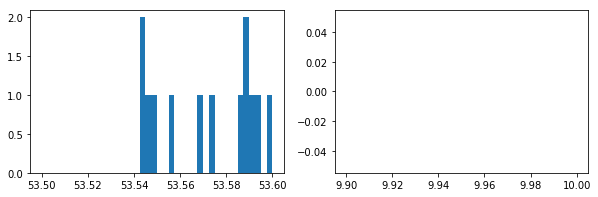

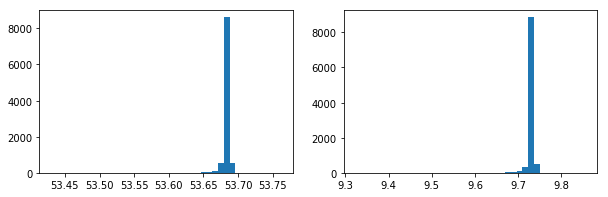

In [168]:
P_crop_ba_2 = []
for i in range(n_cam):
    K, R, T, Ccam = ba_utils.decompose_projection_matrix(P_crop_ba[i])
    #newR = np.linalg.inv(R_google) @ R
    Prec = K @ R @ np.hstack((np.eye(3), - Ccam[:, np.newaxis]))
    P_crop_ba_2.append( R_google @ Prec)
    



col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba_2[q], P_crop_ba_2[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        print(q,p)
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_last_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])
        
        _,f = plt.subplots(1, 2, figsize=(10,3))
        f[0].hist(lat, range=(53.5, 53.6), bins=40); 
        f[1].hist(lon, range=(9.9, 10.0), bins=40);
        
        _,f2 = plt.subplots(1, 2, figsize=(10,3))
        f2[0].hist(lat, bins=40); 
        f2[1].hist(lon, bins=40);        
        
        break
    break